In [296]:
import os
import xarray as xr
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

In [297]:
DATA_DIR = '/wind/LMU/' if os.getlogin() == 'martin' else '/local/S.Rasp/ML-Workshop-Data/dataset2/'

In [298]:
!ls $DATA_DIR

conda_env.def	     nwp_ecmwf-ifs.nc		     totoral_scada_lmu_filt.h5
create_patterns.py   nwp_envca-gdps.nc		     totoral_scada_lmu.h5
forecast_errors.png  nwp_ncep-gfs4.nc		     W2W-ML-Workshop
ingest.py	     patdef_LMU.yaml		     windfarm.jpg
kaggle.json	     power_curve_single_turbine.png  windpark.nc
metobs.nc	     README.md
ml_workshop_data.7z  targets.png


## Check out the data

### NWP data

In [299]:
nwp_ec = xr.open_dataset(DATA_DIR + 'nwp_ecmwf-ifs.nc')
nwp_en = xr.open_dataset(DATA_DIR + 'nwp_envca-gdps.nc')
nwp_nc = xr.open_dataset(DATA_DIR + 'nwp_ncep-gfs4.nc')

In [300]:
nwps = [nwp_ec, nwp_en, nwp_nc]
nwps

[<xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) int64 1420070400 1420113600 1420156800 1420200000 ...
   * offset_s  (offset_s) int64 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     t2m       (epoch_s, offset_s) float32 ...
     ws100m    (epoch_s, offset_s) float32 ...
     wd100m    (epoch_s, offset_s) float32 ...
     ws10m     (epoch_s, offset_s) float32 ...
     blh       (epoch_s, offset_s) float32 ...
     wd10m     (epoch_s, offset_s) float32 ..., <xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) int64 1420070400 1420113600 1420156800 1420200000 ...
   * offset_s  (offset_s) int64 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     q         (epoch_s, offset_s) float32 ...
     t2m       (epoch_s, offset_s) float32 ...
     wd1000mb  (epoch_s, offset_s) float32 ...
     tclcov    (epoch_s, offset_s) float32 ...
     ws925mb   (epoch_s,

In [301]:
np.isnan(nwp_nc.ws10m.values).shape

(2925, 49)

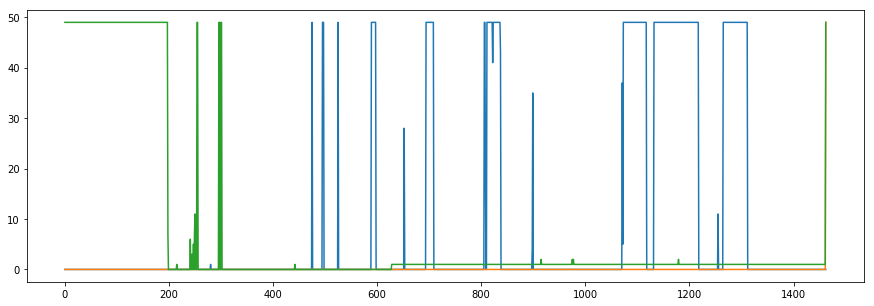

In [302]:
fig = plt.figure(figsize=(15, 5))
plt.plot(np.isnan(nwp_en.ws1000mb.values).sum(1))
plt.plot(np.isnan(nwp_ec.ws100m.values).sum(1))
plt.plot(np.isnan(nwp_nc.ws100m[::2].values).sum(1))

In [303]:
# Convert POSIX to datetime
for nwp in nwps:
    nwp['epoch_s'] = pd.to_datetime(nwp.epoch_s, unit='s')

In [304]:
nwps

[<xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
   * offset_s  (offset_s) int64 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     t2m       (epoch_s, offset_s) float32 ...
     ws100m    (epoch_s, offset_s) float32 5.862752 6.4898725 5.634605 ...
     wd100m    (epoch_s, offset_s) float32 ...
     ws10m     (epoch_s, offset_s) float32 ...
     blh       (epoch_s, offset_s) float32 ...
     wd10m     (epoch_s, offset_s) float32 ..., <xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
   * offset_s  (offset_s) int64 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     q         (epoch_s, offset_s) float32 ...
     t2m       (epoch_s, offset_s) float32 ...
     wd1000mb  (epoch_s, offset_s) float32 ...
     tclcov    (epoch_s, offset_s) float32 ...
    

In [305]:
for nwp in nwps:
    print(nwp.epoch_s.min(), nwp.epoch_s.max())

<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')


In [306]:
nwp_ec.offset_s.max() / 60 / 60, (nwp_ec.offset_s[1] - nwp_ec.offset_s[0]) / 60

(<xarray.DataArray 'offset_s' ()>
 array(144.), <xarray.DataArray 'offset_s' ()>
 array(180.))

In [307]:
4*24

96

## Mast data

In [308]:
met = xr.open_dataset(DATA_DIR + 'metobs.nc'); met

<xarray.Dataset>
Dimensions:  (epoch_s: 63072)
Coordinates:
  * epoch_s  (epoch_s) int64 1420070400 1420071300 1420072200 1420073100 ...
Data variables:
    wd_avg   (epoch_s) float32 ...
    ws34m    (epoch_s) float32 ...
    ws_avg   (epoch_s) float32 ...
    ws80m    (epoch_s) float32 ...

In [309]:
# Convert to date time
met['epoch_s'] = pd.to_datetime(met.epoch_s, unit='s')

In [310]:
met.epoch_s.min(), met.epoch_s.max(), met.epoch_s[1] - met.epoch_s[0]

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:45:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array(900000000000, dtype='timedelta64[ns]'))

In [311]:
900000000000 / 1e9 / 60

15.0

## Target wind production data

In [312]:
pwr = xr.open_dataset(DATA_DIR + 'windpark.nc'); pwr

<xarray.Dataset>
Dimensions:   (epoch_s: 94608)
Coordinates:
  * epoch_s   (epoch_s) int64 1420070400 1420071000 1420071600 1420072200 ...
Data variables:
    rawpower  (epoch_s) float32 ...
    power     (epoch_s) float32 ...

In [313]:
# Convert to date time
pwr['epoch_s'] = pwr.epoch_s.values.astype('datetime64[s]')

In [314]:
pwr.epoch_s.min(), pwr.epoch_s.max(), pwr.epoch_s[1] - pwr.epoch_s[0]

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:50:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array(600000000000, dtype='timedelta64[ns]'))

In [315]:
600000000000 / 1e9 / 60

10.0

## EDA

(0, 1)

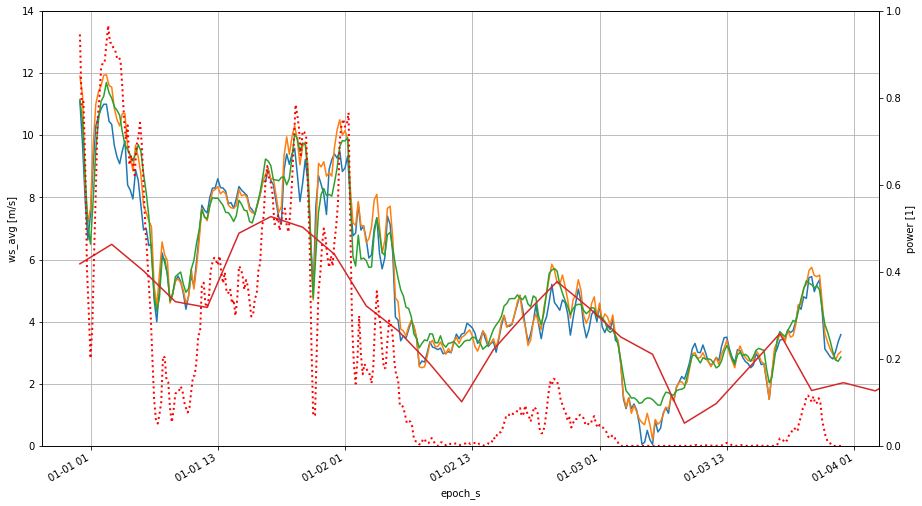

In [316]:
fig = plt.figure(figsize=(15, 8))
met.ws34m.sel(epoch_s=slice('2015-01-01', '2015-01-03')).plot()
met.ws80m.sel(epoch_s=slice('2015-01-01', '2015-01-03')).plot()
met.ws_avg.sel(epoch_s=slice('2015-01-01', '2015-01-03')).plot()
plt.plot(np.datetime64('2015-01-01', 's') + nwp_ec.offset_s, nwp_ec.ws100m.sel(epoch_s='2015-01-01T00'))
plt.grid()
plt.ylim(0, 14)
ax2 = plt.gca().twinx()
pwr.power.sel(epoch_s=slice('2015-01-01', '2015-01-03')).plot(c='r', ls=':', lw=2)
plt.ylim(0, 1)

### Wind farm power curve
The difference between `rawpower` and `power` is not only the removal of obviously wrong power values, but also the correction of the relative farm production in cases where one or several turbines do not contribute due to failure or maintainance.

In [317]:
intersect = np.intersect1d(met.epoch_s, pwr.epoch_s)
print(intersect.shape, pwr.epoch_s.shape)
print(np.isfinite(pwr.rawpower.values).sum(), np.isfinite(pwr.power.values).sum())


(31536,) (94608,)
94608 92568


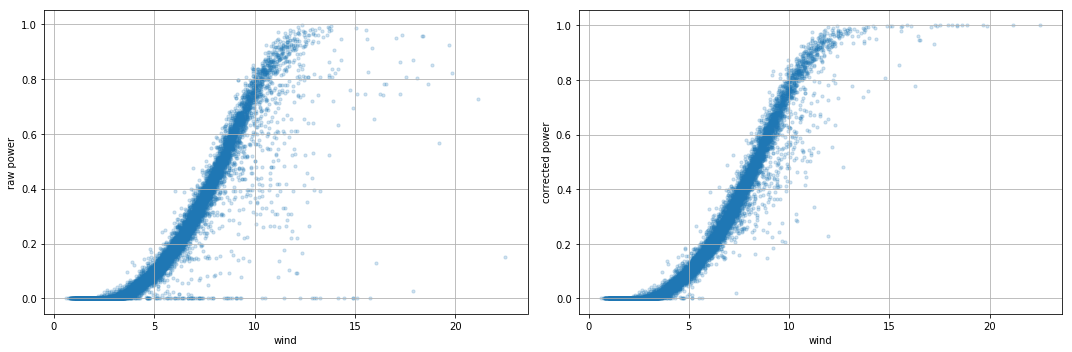

In [318]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.scatter(met.ws_avg.sel(epoch_s=intersect[::2]), pwr.rawpower.sel(epoch_s=intersect[::2]), s=10, alpha=0.2, 
           label='rawpower')
plt.xlabel('wind'); plt.ylabel('raw power'); plt.grid()
plt.subplot(122)
plt.scatter(met.ws_avg.sel(epoch_s=intersect[::2]), pwr.power.sel(epoch_s=intersect[::2]), s=10, alpha=0.2,
           label='power')
plt.xlabel('wind'); plt.ylabel('corrected power'); plt.grid()
plt.tight_layout()

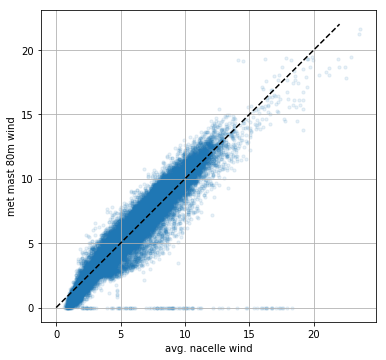

In [319]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(met.ws_avg, met.ws80m, s=10, alpha=0.1)
plt.gca().set_aspect(1.0)
plt.plot([0, 22], [0, 22], 'k--')
plt.xlabel('avg. nacelle wind'); plt.ylabel('met mast 80m wind'); plt.grid()

## Split into datasets and prepare

Total roughly 22 months. For better training results, the validation set should be scattered among the training data, otherwise we focus too much on certain weather situations. Since the correlations are too high between neighboring patterns, split data blockwise.

In [320]:
fc_lead = np.timedelta64(4*24*60*60+1, 's')  # 4 days
pattern_step_h = 3
full_range = np.arange('2015-01-01', np.datetime64('2016-10-18T23:50') - fc_lead, 
                          np.timedelta64(pattern_step_h, 'h'), dtype='datetime64[s]')

# use certain months as test set, to get a good performance estimate for all seasons
test_range = []
for yr, mo in [[2015, 3], [2015, 5], [2015, 7], [2015, 11], [2016, 3], [2016, 8]]:
    test_range.extend(np.arange(f'{yr}-{mo:02d}-01', f'{yr}-%02d-01' % (mo + 1), 
                          np.timedelta64(3, 'h'), dtype='datetime64[s]').tolist())
test_range = np.array(test_range, dtype='datetime64[s]')
exploration_range = np.setdiff1d(full_range, test_range)
print('full:', full_range.size)
print('exp:', exploration_range.size)


full: 5224
exp: 3744


In [321]:
# use (approximately) two days of every 20-day-block as validation set
twenty_days = 20 * 24 // pattern_step_h
two_days = twenty_days//10
print(twenty_days)
val_idx_offs = 100
cropsize = twenty_days * (exploration_range.size // twenty_days)
validation_range = exploration_range[:cropsize].reshape(
    -1, twenty_days)[:, val_idx_offs:val_idx_offs + two_days].flatten()
training_range = np.setdiff1d(exploration_range, validation_range)
print('trn/val/tst: {}/{}/{}'.format(training_range.size, validation_range.size, test_range.size))

160
trn/val/tst: 3376/368/1480


In [322]:
def split(ds):
    return ds.sel(epoch_s=train_range), ds.sel(epoch_s=validation_range), ds.sel(epoch_s=test_range)

### Option 1: Latest available NWP

In [323]:
nwp_ec

<xarray.Dataset>
Dimensions:   (epoch_s: 1463, offset_s: 49)
Coordinates:
  * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
  * offset_s  (offset_s) int64 0 10800 21600 32400 43200 54000 64800 75600 ...
Data variables:
    t2m       (epoch_s, offset_s) float32 ...
    ws100m    (epoch_s, offset_s) float32 5.862752 6.4898725 5.634605 ...
    wd100m    (epoch_s, offset_s) float32 ...
    ws10m     (epoch_s, offset_s) float32 ...
    blh       (epoch_s, offset_s) float32 ...
    wd10m     (epoch_s, offset_s) float32 ...

In [324]:
train_range.start

'2015-01-01T12'

In [325]:
t = full_range[5]; t

numpy.datetime64('2015-01-01T15:00:00')

In [326]:
e = nwp_ec.sel(epoch_s=t, method='ffill'); e

<xarray.Dataset>
Dimensions:   (offset_s: 49)
Coordinates:
    epoch_s   datetime64[ns] 2015-01-01T12:00:00
  * offset_s  (offset_s) int64 0 10800 21600 32400 43200 54000 64800 75600 ...
Data variables:
    t2m       (offset_s) float32 ...
    ws100m    (offset_s) float32 4.3994155 6.4284925 6.897442 6.7948046 ...
    wd100m    (offset_s) float32 ...
    ws10m     (offset_s) float32 ...
    blh       (offset_s) float32 ...
    wd10m     (offset_s) float32 ...

In [327]:
offset = int(t - e.epoch_s) / 1e9; offset

10800.0

In [328]:
fc_lead_s = fc_lead.astype(int)
fc_buffer_s = 6 * 3600 # use a bit more of the forecast than needed

In [329]:
e = e.sel(offset_s=slice(offset, offset + fc_lead_s + fc_buffer_s))

In [330]:
for v in e.data_vars:
    print(e[v].values)

[291.7827  293.70923 292.81348 288.52612 288.0464  286.7522  286.23267
 290.91406 294.05786 294.97412 294.12134 290.9807  289.1494  288.12524
 288.77686 291.34644 294.2417  295.49048 295.50195 291.34644 290.15942
 289.90894 289.47388 291.04565 294.43604 295.88257 295.23242 291.85767
 290.57275 289.76    289.91382 291.16968 293.36548 294.0432  293.64624]
[6.4284925  6.897442   6.7948046  6.3457937  3.928542   3.4847076
 2.7889655  1.2320387  2.8469672  3.8087401  4.877701   4.397404
 3.3757873  2.7967007  0.49587205 1.847047   2.1877742  3.2826273
 2.2953465  2.5069966  1.6592269  1.5212464  0.59574175 0.7468205
 1.977998   2.9243217  2.5525994  1.6149657  0.5815424  0.31366426
 1.1908911  2.3319073  4.1420865  3.523986   2.3059907 ]
[ 21.58099    21.41783    12.763775    6.812135  340.5808    351.71967
 328.52893    30.612179   81.60294    63.638134   23.909637  355.93286
 346.1759    351.1611    321.65576   118.88919    77.68933    60.44971
  53.111057  358.1216    345.5724    343.440

In [331]:
def get_latest_fc(t, nwps, flatten=True):
    a = []
    for nwp in nwps[:1]:
        e = nwp.sel(epoch_s=t, method='ffill')
        offset = int(t - e.epoch_s) / 1e9
        e = e.sel(offset_s=slice(offset, offset + fc_lead_s + fc_buffer_s))
        for v in e.data_vars:
            a.append(e[v].values)
    a = np.array(a)
    return a.reshape(-1) if flatten else a

In [332]:
# validation set
validation_inputs = np.vstack([get_latest_fc(t, nwps, flatten=True) for t in validation_range])
print(validation_inputs.shape)

(368, 210)


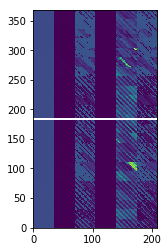

In [333]:
plt.imshow(validation_set, origin='lower')
plt.plot(np.isnan(validation_set).sum(0) + validation_set.shape[0] / 2, 'w', lw=2)

In [334]:
fc_resol_s = 10 * 60
time_idxs = np.arange(t, t + fc_lead_s, np.timedelta64(fc_resol_s, 's'), dtype='datetime64[ns]')

In [335]:
pwr.power.sel(epoch_s=time_idxs)

<xarray.DataArray 'power' (epoch_s: 577)>
array([0.413228, 0.408215, 0.392715, ..., 0.005059, 0.004411, 0.002348],
      dtype=float32)
Coordinates:
  * epoch_s  (epoch_s) datetime64[s] 2015-01-01T15:00:00 2015-01-01T15:10:00 ...
Attributes:
    units:    1
    descr:    filtered normalized wind park power output

In [336]:
def get_y(t, da=pwr.power, dt=np.timedelta64(3600, 's')):
    time_idxs = np.arange(t, t + fc_lead_s, dt, dtype='datetime64[ns]')
    return da.sel(epoch_s=time_idxs).values

In [337]:
t

numpy.datetime64('2015-01-01T15:00:00')

In [338]:
print(get_y(t).shape)

(97,)


In [339]:
def generate_patterns_nwp_only(timestamps):
    X_train, y_train = [], []
    for t in tqdm(timestamps):
        X_train.append(get_latest_fc(t, nwps))
        y_train.append(get_y(t, pwr.power, dt=np.timedelta64(1, 'h')))
    return np.array(X_train), np.array(y_train)

In [340]:
X_train, y_train = generate_patterns_nwp_only(training_range)
X_valid, y_valid = generate_patterns_nwp_only(validation_range)
X_test, y_test = generate_patterns_nwp_only(test_range)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3376, 210), (3376, 97), (368, 210), (368, 97))

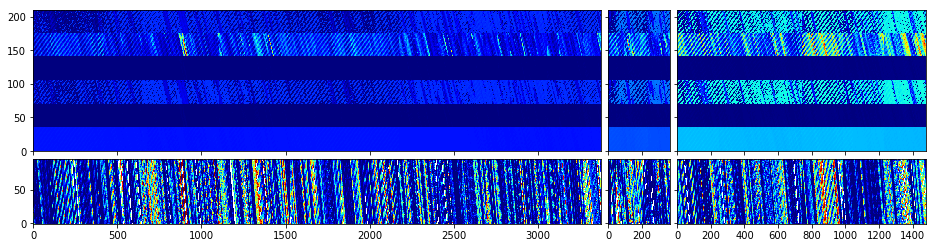

In [341]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(16, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),
                 axes_pad=0.1, aspect='auto',
                 add_all=True,
                 label_mode="L")
for i, p in enumerate([X_train, X_valid, X_test, y_train, y_valid, y_test]):
    grid[i].imshow(p.T, origin='lower', interpolation="nearest", cmap='jet', aspect=4.0)

Now check the distribution of targets in the different sets, to make sure we are not biased towards high or low yield in any of them. 

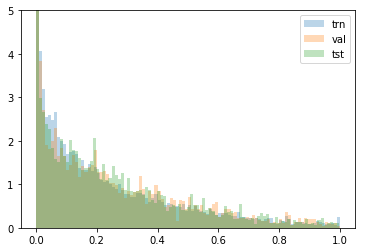

In [342]:
for label, s in zip(['trn', 'val', 'tst'], [y_train, y_valid, y_test]):
    valid = np.isfinite(s.flatten())
    plt.hist(s.flatten()[valid], bins=100, alpha=0.3, density=True, label=label)
plt.ylim(0,5)
plt.legend()

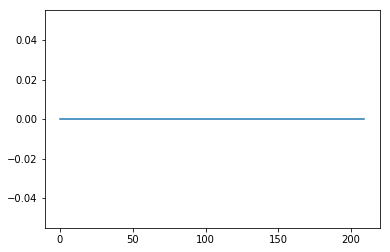

In [343]:
plt.plot(np.isnan(X_train).sum(0))

0.020496408853276006


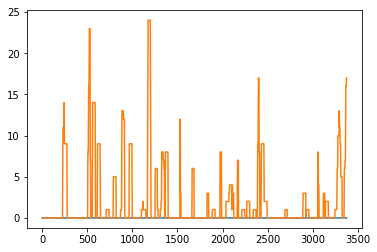

In [396]:
plt.plot(np.isnan(X_train).sum(1))
plt.plot(np.isnan(y_train).sum(1))
print(np.isnan(y_train).sum()/y_train.size)

In [345]:
X_train[np.isnan(X_train)] = np.nanmean(X_train)
X_valid[np.isnan(X_valid)] = np.nanmean(X_valid)
y_train_fixed = y_train.copy()
y_train_fixed[np.isnan(y_train_fixed)] = np.nanmean(y_train)
y_valid_fixed = y_valid.copy()
y_valid_fixed[np.isnan(y_valid_fixed)] = np.nanmean(y_train)

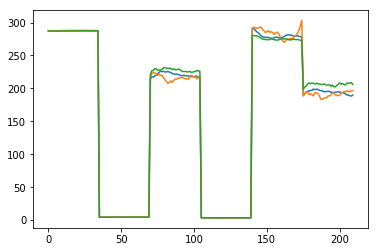

In [346]:
plt.plot(X_train.mean(0))
plt.plot(X_valid.mean(0))
plt.plot(X_test.mean(0))

In [445]:
def rmseplot(models, dset='val', ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = plt.subplot(111)
    for model in models:
        label = str(type(model)).split('.')[-1].replace('Regressor', '')[:-2]
        X, y = {'trn': [X_train, y_train], 'val': [X_valid, y_valid], 'tst': [X_test, y_test]}[dset]
        ax.plot(rmse(y, model.predict(X), 0), label=label + f' ({dset})')
    plt.legend()
    plt.ylim(bottom=0)
    plt.ylabel('RMSE')

## Linear regression

In [347]:
#normalize
mean, std = X_train.mean(0), X_train.std(0)
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

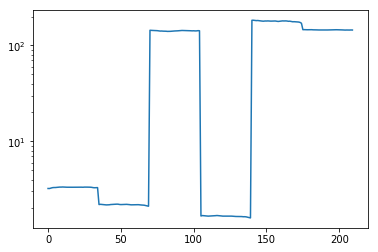

In [348]:
plt.plot(std); plt.yscale('log')

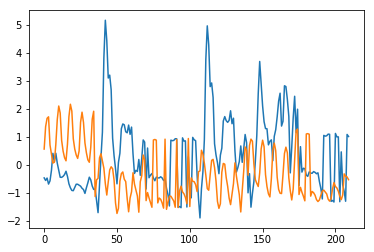

In [349]:
plt.plot(X_train[-1])
plt.plot(X_valid[0])

In [350]:
from sklearn.linear_model import LinearRegression

In [351]:
lr = LinearRegression()
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
lr.fit(X_train, y_train_fixed)

0 6712


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [352]:
lr.score(X_train, y_train_fixed)

0.5196008812444021

In [353]:
lr.score(X_valid, y_valid_fixed)

0.4479072777118116

In [354]:
def mse(y_true, y_pred, axis=(0,1)): return np.nanmean((y_true - y_pred)**2,axis)
def rmse(y_true, y_pred, axis=(0,1)): return np.sqrt(np.nanmean((y_true - y_pred)**2,axis))

In [355]:
mse(y_valid, lr.predict(X_valid))

0.028634481

In [356]:
mse(y_valid, np.ones(y_valid.shape) * np.nanmean(y_train))

0.05413456704850959

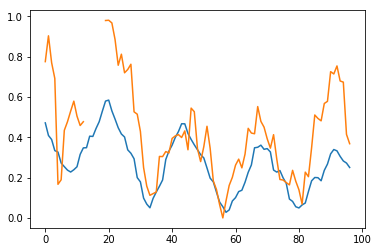

In [357]:
plt.plot(lr.predict(X_valid[180][None])[0])
plt.plot(y_valid[180])

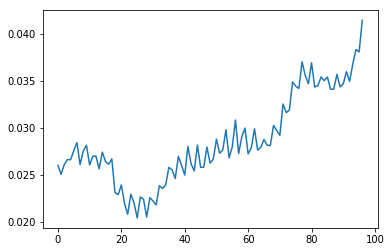

In [358]:
plt.plot(mse(y_valid, lr.predict(X_valid), 0))

## Random forest

In [359]:
from sklearn.ensemble import RandomForestRegressor

In [360]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [361]:
%time rf.fit(X_train, y_train_fixed)

CPU times: user 42.3 s, sys: 40.4 ms, total: 42.3 s
Wall time: 5.54 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [427]:
rf.score(X_train, y_train_fixed), rf.score(X_valid, y_valid_fixed)

sklearn.linear_model.base.LinearRegression

In [363]:
preds = rf.predict(X_valid)

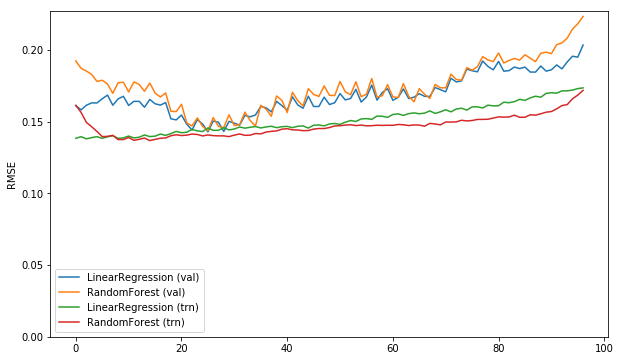

In [447]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
rmseplot([lr, rf], 'val', ax=ax)
rmseplot([lr, rf], 'trn', ax=ax)

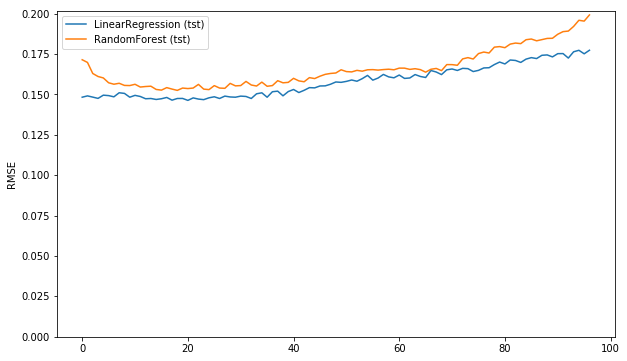

In [449]:
rmseplot([lr, rf], 'tst')

In [130]:
plt.plot(np.mean(y_train_10m, 0))
plt.plot(np.mean(y_valid_10m, 0))

NameError: name 'y_train_10m' is not defined

In [ ]:
i = 100
plt.plot(preds[i])
plt.plot(y_valid[i])

(0, 1)

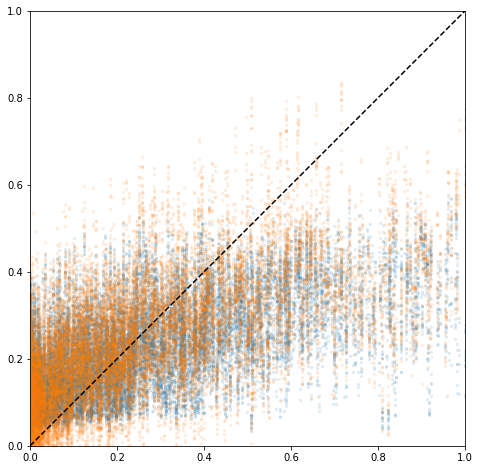

In [367]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(y_valid, rf.predict(X_valid), s=5, alpha=0.1)
plt.scatter(y_valid, lr.predict(X_valid), s=5, alpha=0.1)
plt.gca().set_aspect(1.0)
plt.plot([0,1], [0,1], 'k--')
plt.xlim(0,1) ; plt.ylim(0,1)

## Neural Network w/o early stopping

In [468]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=[32, 32], activation='tanh', max_iter=300)

In [469]:
%time nn.fit(X_train, y_train_fixed)

CPU times: user 2.48 s, sys: 149 ms, total: 2.63 s
Wall time: 661 ms


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[32, 32], learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [470]:
nn.score(X_train, y_train_fixed), nn.score(X_valid, y_valid_fixed)

(0.5083644740779372, 0.4582238769649845)

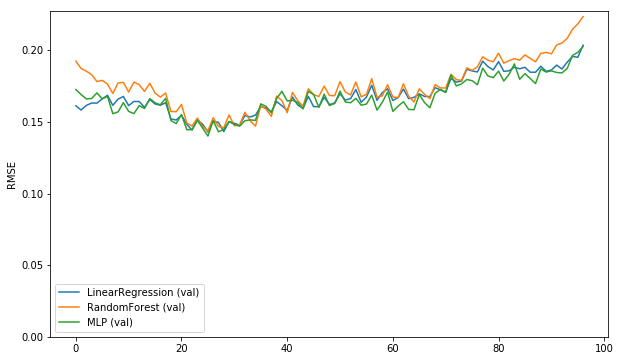

In [473]:
rmseplot([lr, rf, nn], 'val')

## Neural Network with validation set
There is an option `early_stopping` which automatically sets aside a randomly selected validation set. However, we have to do our own validation since our validation data is specially constructed.

In [484]:
steps_per_validation = 100
nn = MLPRegressor(hidden_layer_sizes=[32, 32], activation='tanh', max_iter=steps_per_validation, tol=-1)

In [485]:
best_score = 0
best_epoch = 0
tolerance = 500  # epochs to continue, looking for better score
i = 0
while True:
    i += 1
    nn.fit(X_train, y_train_fixed)
    new_score = nn.score(X_valid, y_valid_fixed)
    epoch = i * nn.max_iter
    print(f'{epoch:05d}  {new_score:8.5f}  {best_score:8.5f}')
    if new_score > best_score:
        best_score = new_score
        best_model = nn
        best_epoch = epoch
    if epoch - best_epoch > tolerance:
        break
    nn = MLPRegressor(hidden_layer_sizes=[32, 32], activation='tanh', max_iter=steps_per_validation,
                     warm_start=True, tol=-1)
print('Training finished!')
nn = best_model

/home/martin/.conda/envs/lmu/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


00100   0.46742   0.00000
00200   0.46664   0.46742
00300   0.47861   0.46742
00400   0.47817   0.47861
00500   0.47576   0.47861
00600   0.47530   0.47861
00700   0.47943   0.47861
00800   0.47097   0.47943
00900   0.47073   0.47943
01000   0.47879   0.47943
01100   0.46832   0.47943
01200   0.47139   0.47943
01300   0.47506   0.47943


In [486]:
nn.score(X_train, y_train_fixed), nn.score(X_valid, y_valid_fixed)

(0.5943969326853548, 0.4794304400634888)

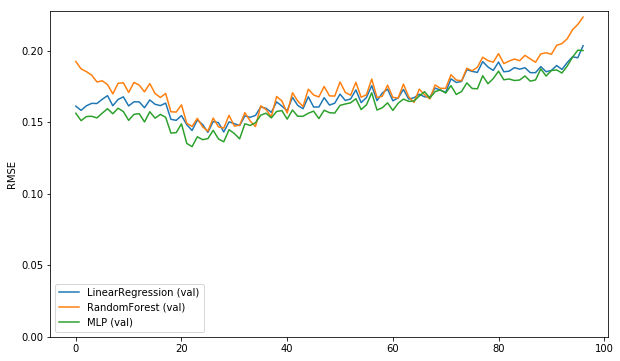

In [489]:
rmseplot([lr, rf, nn], 'val')

In [ ]:
plt.plot(rmse(y_valid, lr.predict(X_valid), 0))
plt.plot(rmse(y_valid, rf.predict(X_valid), 0))
plt.plot(rmse(y_valid, nn.predict(X_valid), 0))

## Add recent observation data

In [368]:
t

numpy.datetime64('2015-01-01T15:00:00')

In [ ]:
t_history = np.timedelta64(6, 'h') # how far back to consider obs data
delay = np.timedelta64(6, 'h')     # delay for NWP delivery, i.e. obs are already available for this time range

In [374]:
time_idxs = np.arange(t-t_history, t, np.timedelta64(30, 'm'), dtype='datetime64[ns]')

In [375]:
time_idxs

array(['2014-12-31T18:00:00.000000000', '2014-12-31T18:30:00.000000000',
       '2014-12-31T19:00:00.000000000', '2014-12-31T19:30:00.000000000',
       '2014-12-31T20:00:00.000000000', '2014-12-31T20:30:00.000000000',
       '2014-12-31T21:00:00.000000000', '2014-12-31T21:30:00.000000000',
       '2014-12-31T22:00:00.000000000', '2014-12-31T22:30:00.000000000',
       '2014-12-31T23:00:00.000000000', '2014-12-31T23:30:00.000000000'],
      dtype='datetime64[ns]')

In [376]:
met.ws80m

<xarray.DataArray 'ws80m' (epoch_s: 63072)>
array([11.9     , 11.283334,  8.35    , ...,  7.666667,  7.75    ,  7.783333],
      dtype=float32)
Coordinates:
  * epoch_s  (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T00:15:00 ...
Attributes:
    units:    m/s
    descr:    wind speed from met mast at 80 m above surface

In [382]:
def get_met_obs(t, t_back=np.timedelta64(6, 'h'), dt=np.timedelta64(15, 'm'), var='ws_avg', 
                delay=np.timedelta64(0, 'h')):
    time_idxs = np.arange(t + delay - t_back, t + delay, dt, dtype='datetime64[ns]')
    return met[var].sel(epoch_s=time_idxs).values

In [383]:
X_obs = []
for t in tqdm(training_range):
    X_obs.append(get_met_obs(t, delay=delay))

In [384]:
X_obs = np.array(X_obs); X_obs.shape

(3376, 24)

In [385]:
X_obs.size

81024

In [386]:
np.isnan(X_obs).sum()/X_obs.size

0.009676145339652449

In [387]:
X_obs[np.isnan(X_obs)] = np.nanmean(X_obs)

In [388]:
X_train2 = np.hstack([X_train, X_obs]); X_train2.shape, X_train.shape

((3376, 234), (3376, 210))

In [389]:
X_obs = []
for t in tqdm(validation_range):
    X_obs.append(get_met_obs(t, delay=delay))

In [390]:
X_obs = np.array(X_obs); X_obs.shape

(368, 24)

In [391]:
X_obs[np.isnan(X_obs)] = np.nanmean(X_obs)

In [393]:
X_valid2 = np.hstack([X_valid, X_obs]); X_valid2.shape, X_valid.shape

((368, 234), (368, 210))

### train models again

In [394]:
rf2 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [397]:
%time rf2.fit(X_train2, y_train_fixed)

CPU times: user 46.9 s, sys: 34.4 ms, total: 46.9 s
Wall time: 6.13 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [399]:
rf.score(X_train, y_train_fixed), rf.score(X_valid, y_valid_fixed)

(0.5679101714630859, 0.4178864813618568)

In [401]:
rf2.score(X_train2, y_train_fixed), rf2.score(X_valid2, y_valid_fixed)

(0.5730097057647572, 0.43057464655585126)

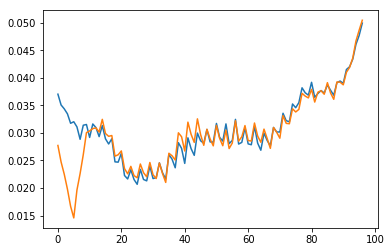

In [402]:
plt.plot(mse(y_valid, rf.predict(X_valid), 0))
plt.plot(mse(y_valid, rf2.predict(X_valid2), 0))

### Weight by fc lead time

In [403]:
y_train.shape

(3376, 97)

In [405]:
weight = np.linspace(2, 1, y_train.shape[1]); weight

array([2.        , 1.98958333, 1.97916667, 1.96875   , 1.95833333,
       1.94791667, 1.9375    , 1.92708333, 1.91666667, 1.90625   ,
       1.89583333, 1.88541667, 1.875     , 1.86458333, 1.85416667,
       1.84375   , 1.83333333, 1.82291667, 1.8125    , 1.80208333,
       1.79166667, 1.78125   , 1.77083333, 1.76041667, 1.75      ,
       1.73958333, 1.72916667, 1.71875   , 1.70833333, 1.69791667,
       1.6875    , 1.67708333, 1.66666667, 1.65625   , 1.64583333,
       1.63541667, 1.625     , 1.61458333, 1.60416667, 1.59375   ,
       1.58333333, 1.57291667, 1.5625    , 1.55208333, 1.54166667,
       1.53125   , 1.52083333, 1.51041667, 1.5       , 1.48958333,
       1.47916667, 1.46875   , 1.45833333, 1.44791667, 1.4375    ,
       1.42708333, 1.41666667, 1.40625   , 1.39583333, 1.38541667,
       1.375     , 1.36458333, 1.35416667, 1.34375   , 1.33333333,
       1.32291667, 1.3125    , 1.30208333, 1.29166667, 1.28125   ,
       1.27083333, 1.26041667, 1.25      , 1.23958333, 1.22916

In [406]:
rf3 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [408]:
%time rf3.fit(X_train2, y_train_fixed * weight)

CPU times: user 47 s, sys: 54.1 ms, total: 47 s
Wall time: 6.13 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [410]:
rf3.score(X_train2, y_train_fixed*weight), rf3.score(X_valid2, y_valid_fixed*weight)

(0.5945432522553384, 0.4541533938105702)

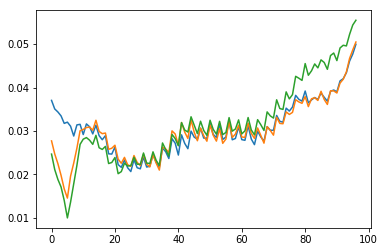

In [411]:
plt.plot(mse(y_valid, rf.predict(X_valid), 0))
plt.plot(mse(y_valid, rf2.predict(X_valid2), 0))
plt.plot(mse(y_valid, rf3.predict(X_valid2)/weight, 0))

### Separate models

In [412]:
rf_early = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [413]:
y_train.shape

(3376, 97)

In [414]:
%time rf_early.fit(X_train2, y_train_fixed[:, :25])

CPU times: user 23.8 s, sys: 11.5 ms, total: 23.8 s
Wall time: 3.13 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [415]:
rf_late = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [416]:
%time rf_late.fit(X_train2, y_train_fixed[:, 25:])

CPU times: user 39.7 s, sys: 28.8 ms, total: 39.7 s
Wall time: 5.38 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [417]:
preds_concat = np.hstack([rf_early.predict(X_valid2), rf_late.predict(X_valid2)]); preds_concat.shape

(368, 97)

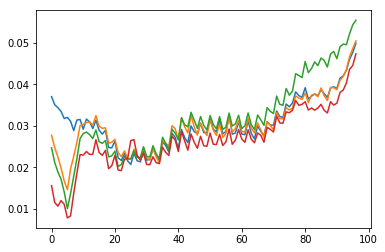

In [418]:
plt.plot(mse(y_valid, rf.predict(X_valid), 0))
plt.plot(mse(y_valid, rf2.predict(X_valid2), 0))
plt.plot(mse(y_valid, rf3.predict(X_valid2)/weight, 0))
plt.plot(mse(y_valid, preds_concat, 0))

### 10 minute interval forecasts

In [206]:
y_train_10m = []
every_3_hours_train = every_3_hours[(every_3_hours >= np.datetime64(train_range.start)) & 
                                    (every_3_hours <= np.datetime64(train_range.stop))]
for t in tqdm(every_3_hours_train):
    y_train_10m.append(get_y(t, dt=np.timedelta64(10, 'm')))

In [207]:
y_valid_10m = []
for t in tqdm(every_3_hours_valid):
    y_valid_10m.append(get_y(t, dt=np.timedelta64(10, 'm')))

In [208]:
y_train_10m = np.array(y_train_10m)
y_valid_10m = np.array(y_valid_10m)
y_train_10m.shape, y_valid_10m.shape, y_train.shape

((2909, 577), (961, 577), (2909, 33))

In [209]:
rf_10m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [210]:
%time rf_10m.fit(X_train2, y_train_10m)

CPU times: user 12min 13s, sys: 172 ms, total: 12min 13s
Wall time: 39.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [213]:
rf2.score(X_train2, y_train), rf2.score(X_valid2, y_valid)

(0.5954800844911506, 0.4425051260286215)

In [212]:
rf_10m.score(X_train2, y_train_10m), rf_10m.score(X_valid2, y_valid_10m)

(0.5945406041224824, 0.4396679652228934)

In [214]:
preds = rf_10m.predict(X_valid2)

In [215]:
preds.shape, y_valid_10m.shape

((961, 577), (961, 577))

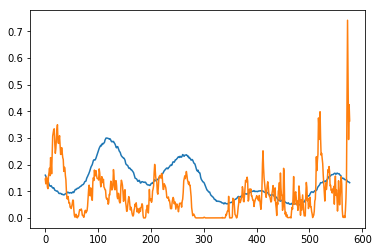

In [216]:
i = 0
plt.plot(preds[i])
plt.plot(y_valid_10m[i])

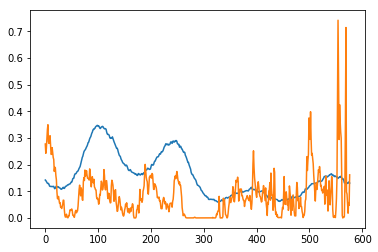

In [218]:
i = 1
plt.plot(preds[i])
plt.plot(y_valid_10m[i])